In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from metpy.calc import heat_index
from metpy.units import units

from tqdm import tqdm
from matplotlib import pyplot as plt

## Load citywide time-series data for different heat-related impacts

In [8]:
def produce_time_series_data(outcome_var, level, filename, type='daily'):
    df = pd.read_parquet(f"output/{filename}")
    df_weather = pd.read_parquet(f"output/nws_weather_{type}.parquet")
    df_timeseries = df.groupby(['date','year','month'])[outcome_var].sum().reset_index()\
        .merge(df_weather, on='date', how='left')
    df_timeseries['heat_index'] = df_timeseries['heat_index'].fillna(0)
    df_timeseries = df_timeseries[df_timeseries['year'] >= 2021]
    return df_timeseries
df_timeseries_ems = produce_time_series_data("ems_count", "zip", "ems_count_zip.parquet")
df_timeseries_dps = produce_time_series_data("CUSTOMERS_OUT", "dps", "outage_dps.parquet")
df_timeseries_hydrant = produce_time_series_data("count_hydrant", "tract", "hydrant_tract.parquet")

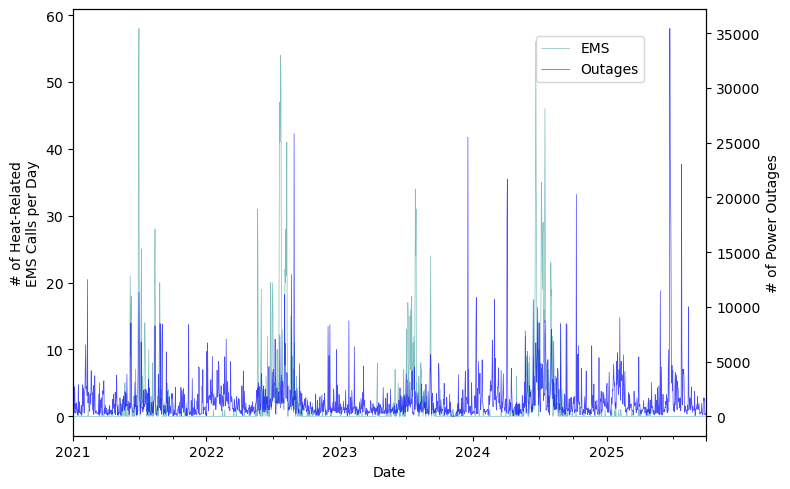

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
df_timeseries_ems.set_index('date')['ems_count'].plot(ax=ax, color='teal', alpha=0.5, linewidth=0.5, label='EMS')
ax2 = ax.twinx()
df_timeseries_dps.set_index('date')['CUSTOMERS_OUT'].plot(ax=ax2, color='blue', alpha=0.7, linewidth=0.5, label='Outages')
ax.set_ylabel('# of Heat-Related\nEMS Calls per Day')
ax2.set_ylabel('# of Power Outages')
ax.set_xlabel('Date')
plt.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.82,0.93))
plt.savefig("./figures/ems_calls_timeseries.pdf")

In [10]:
station = 'USW00094728' # STATION FOR CENTRAL PARK
df_lcds = []
for yr in range(2017,2026):
    df_lcds += [pd.read_csv(f"https://www.ncei.noaa.gov/oa/local-climatological-data/v2/access/{yr}/LCD_{station}_{yr}.csv")]
df_lcd = pd.concat(df_lcds, axis=0)
df_lcd['full_date'] = pd.to_datetime(df_lcd['DATE'])
df_lcd['date'] = pd.to_datetime(df_lcd['full_date']).dt.date
df_lcd['HourlyDryBulbTemperature'] = (df_lcd['HourlyDryBulbTemperature']*9/5) + 32
df_lcd['heat_index'] = heat_index(df_lcd['HourlyDryBulbTemperature'].values * units.degF, df_lcd['HourlyRelativeHumidity'].values * units.percent)
df_lcd = df_lcd[['STATION', 'full_date', 'date', 'heat_index']]
df_lcd_daily = df_lcd.groupby(['date'], as_index=False)['heat_index'].max().rename({'heat_index':'heat_index_mean'})


/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_41655/1893575428.py:4: DtypeWarning: Columns (0: MonthlyGreatestSnowfall, 1: MonthlyTotalSnowfall) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lcds += [pd.read_csv(f"https://www.ncei.noaa.gov/oa/local-climatological-data/v2/access/{yr}/LCD_{station}_{yr}.csv")]
/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_41655/1893575428.py:4: DtypeWarning: Columns (0: DailySnowDepth, 1: MonthlyGreatestSnowfall, 2: MonthlyTotalSnowfall) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lcds += [pd.read_csv(f"https://www.ncei.noaa.gov/oa/local-climatological-data/v2/access/{yr}/LCD_{station}_{yr}.csv")]
/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_41655/1893575428.py:4: DtypeWarning: Columns (0: MonthlyGreatestSnowfall, 1: MonthlyTotalSnowfall) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lcds += [pd.read_csv(f"https://w

In [11]:
df_lcd_daily['date'] = pd.to_datetime(df_lcd_daily['date'])
df_timeseries_ems = df_timeseries_ems.drop(columns='heat_index').merge(df_lcd_daily, on='date', how='left')

In [12]:
df_timeseries_dps = df_timeseries_dps.drop(columns='heat_index').merge(df_lcd_daily, on='date', how='left')

In [13]:
heat_dates = df_timeseries_ems[df_timeseries_ems['nycem_heat_event']==1]['date']

### Seasonal trends in heat-related EMS Calls

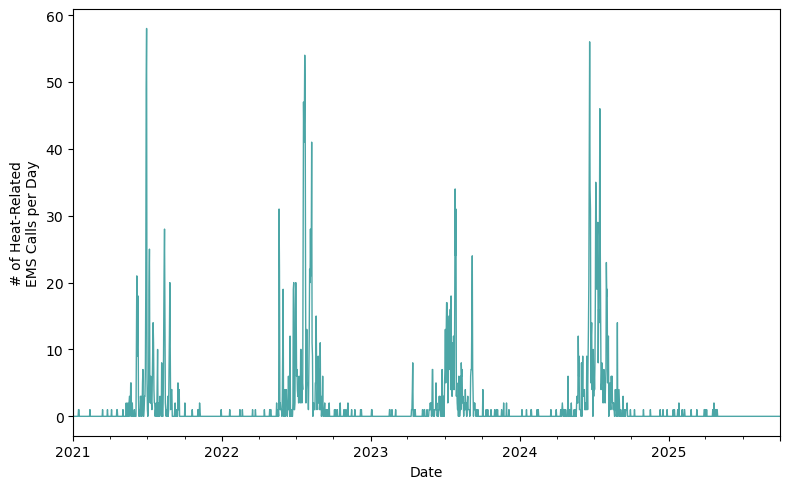

In [15]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
df_timeseries_ems.set_index('date')['ems_count'].plot(ax=ax, color='teal', alpha=0.7, linewidth=1)
plt.ylabel('# of Heat-Related\nEMS Calls per Day')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig("./figures/ems_calls_timeseries.pdf")

### Loading Data on Heat-related EMS Calls

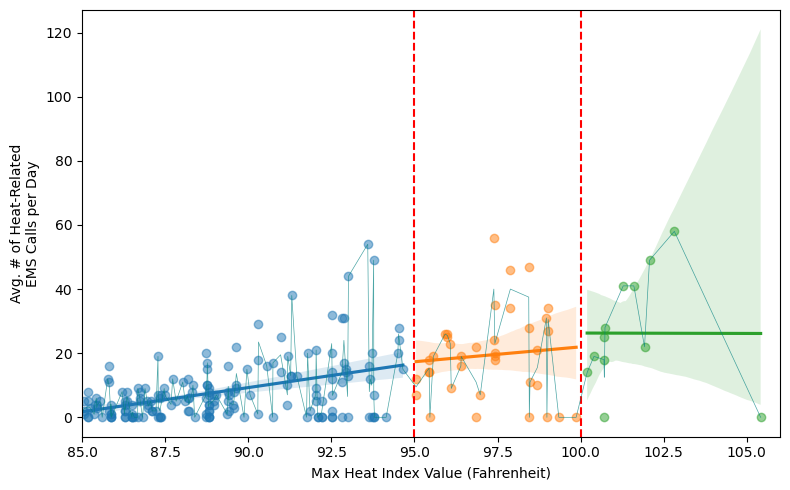

In [16]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.axvline(95, linestyle='dashed', color='red')
plt.axvline(100, linestyle='dashed', color='red')
# ax2=ax.twinx()
# df_timeseries_dps.groupby('heat_index')['CUSTOMERS_OUT'].mean().plot(ax=ax2, color='blue', alpha=0.7, linewidth=0.5)
# ax2.set_ylabel('Avg. # of Outages\nper Day')
sns.regplot(ax=ax, x='heat_index', y='ems_count', data=df_timeseries_ems[(df_timeseries_ems['heat_index']<95)&(df_timeseries_ems['heat_index']>=85)], ci=95, n_boot=1000, scatter_kws={'alpha': 0.5})
sns.regplot(ax=ax, x='heat_index', y='ems_count', data=df_timeseries_ems[(df_timeseries_ems['heat_index']>=95)&(df_timeseries_ems['heat_index']<100)], ci=95, n_boot=1000, scatter_kws={'alpha': 0.5})
sns.regplot(ax=ax, x='heat_index', y='ems_count', data=df_timeseries_ems[(df_timeseries_ems['heat_index']>=100)], ci=95, n_boot=1000, scatter_kws={'alpha': 0.5})
df_timeseries_ems.groupby('heat_index')['ems_count'].mean().plot(ax=ax, color='teal', alpha=0.7, linewidth=0.5)
ax.set_xlabel('Max Heat Index Value (Fahrenheit)')
ax.set_ylabel('Avg. # of Heat-Related\nEMS Calls per Day')
plt.xlim(85,106)
plt.tight_layout()
plt.savefig("./figures/heat_index_comparison.pdf")

### Loading Data from DOHMH on Heat Stress Emergency Department Visits

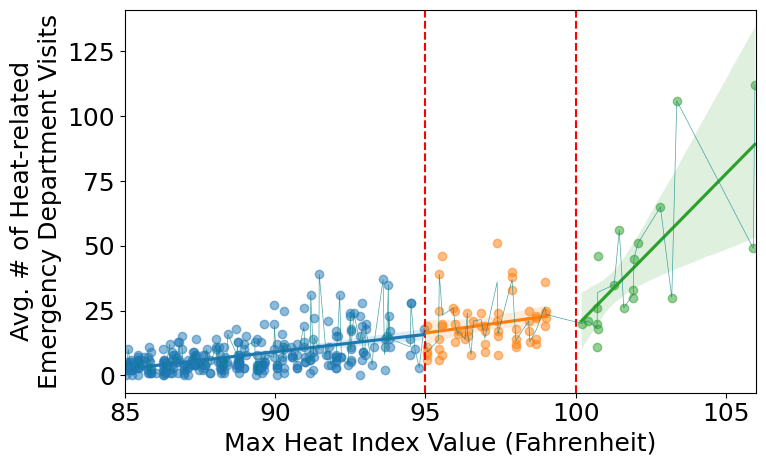

In [ ]:
df_heat_stress = pd.read_csv("https://raw.githubusercontent.com/nychealth/EHDP-data/production/key-topics/heat-syndrome/previous_years.csv")
df_heat_stress['date'] = pd.to_datetime(df_heat_stress['END_DATE'])
df_heat_stress = df_heat_stress.merge(df_lcd_daily, on='date', how='left')

fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.axvline(95, linestyle='dashed', color='red')
plt.axvline(100, linestyle='dashed', color='red')
sns.regplot(ax=ax, x='heat_index', y='HEAT_ED_VISIT_COUNT', data=df_heat_stress[(df_heat_stress['heat_index']<95)&(df_heat_stress['heat_index']>85)], ci=95, n_boot=1000, scatter_kws={'alpha': 0.5})
sns.regplot(ax=ax, x='heat_index', y='HEAT_ED_VISIT_COUNT', data=df_heat_stress[(df_heat_stress['heat_index']>=95)&(df_heat_stress['heat_index']<100)], ci=95, n_boot=1000, scatter_kws={'alpha': 0.5})
sns.regplot(ax=ax, x='heat_index', y='HEAT_ED_VISIT_COUNT', data=df_heat_stress[(df_heat_stress['heat_index']>=100)], ci=95, n_boot=1000, scatter_kws={'alpha': 0.5})
df_heat_stress.groupby('heat_index')['HEAT_ED_VISIT_COUNT'].mean().plot(ax=ax, color='teal', alpha=0.7, linewidth=0.5)
ax.set_xlabel('Max Heat Index Value (Fahrenheit)')
ax.set_ylabel('Avg. # of Heat-related\nEmergency Department Visits')
plt.xlim(85,106)
plt.tight_layout()
plt.savefig("../figures/heat_stress_comparison.pdf")